In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')

import math
import numpy as np
import pandas as pd
import pyBigWig
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from util import array2mat, mat2array
from analyse_util import figure_size, set_plt, set_Border

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gene_positions = {
    'SLC1A2': {'chrom': 'chr11', 'start': 35270000, 'end': 35450000},
    'SLC1A3': {'chrom': 'chr5', 'start': 36600000, 'end': 36690000},
    'GPM6A': {'chrom': 'chr4', 'start': 176550000, 'end': 176930000},
    'MBP': {'chrom': 'chr18', 'start': 74690000, 'end': 74850000},
    'QKI': {'chrom': 'chr6', 'start': 163830000, 'end': 163990000},
    'DOCK10': {'chrom': 'chr2', 'start': 225620000, 'end': 225910000},
}
cell_types = ['Astro', 'ODC']
resolution = 10000

In [3]:
diff_hic_dir = '/lmh_data/work/SEE/analyse/dynamic_interaction/tmp'
diff_hic = {}
for cell_type in cell_types:
    for gene_name in gene_positions.keys():
        diff_hic[(cell_type, gene_name)] = np.load(
            '{}/{}_{}_diffhic.npy'.format(diff_hic_dir, cell_type, gene_name), allow_pickle=True).item()

In [4]:
POLR2A = pyBigWig.open('/lmh_data/data/sclab/source/ENCFF129JPI.hg19.bw')


Astro_H3K27ac = pyBigWig.open('/lmh_data/data/sclab/source/Astro/impute_BSS00089_H3K27ac.bigWig')
Astro_CTCF = pyBigWig.open('/lmh_data/data/sclab/source/Astro/impute_BSS00089_CTCF.bigWig')
Astro_DNase = pyBigWig.open('/lmh_data/data/sclab/source/Astro/impute_BSS00089_DNase-seq.bigWig')
Astro_POLR2A = pyBigWig.open('/lmh_data/data/sclab/source/Astro/impute_BSS00089_POLR2A.bigWig')

ODC_H3K27ac = pyBigWig.open('/lmh_data/data/sclab/source/ODC/GSM7669585_Subject_6-MO.1M.hg19.bw')

In [5]:
def dynamic_vs_ChIP(genes, key, threshold, bw, output_path=None):
    infos = pd.DataFrame()
    for cell_type, gene_name in genes:
        diffhic = diff_hic[(cell_type, gene_name)][key].copy()
        for i in range(diffhic.shape[0]):
            for j in range(i+1, diffhic.shape[0]):
                _chrom, _start = gene_positions[gene_name]['chrom'], gene_positions[gene_name]['start']
                _value = (
                    bw.stats(_chrom, _start + i * resolution, _start + (i+1) * resolution, type="mean", nBins=1)[0] +
                    bw.stats(_chrom, _start + j * resolution, _start + (j+1) * resolution, type="mean", nBins=1)[0]
                ) / 2
                
                if diffhic[i, j] < threshold[0]:
                    dynamic_level = 'other'
                elif diffhic[i, j] < threshold[1]:
                    dynamic_level = 'more dynamic'
                else:
                    dynamic_level = 'most dynamic'
                infos = pd.concat([infos, pd.DataFrame(
                    {'value': [_value], 'dynamic': [dynamic_level],}
                )], axis=0)
    return infos

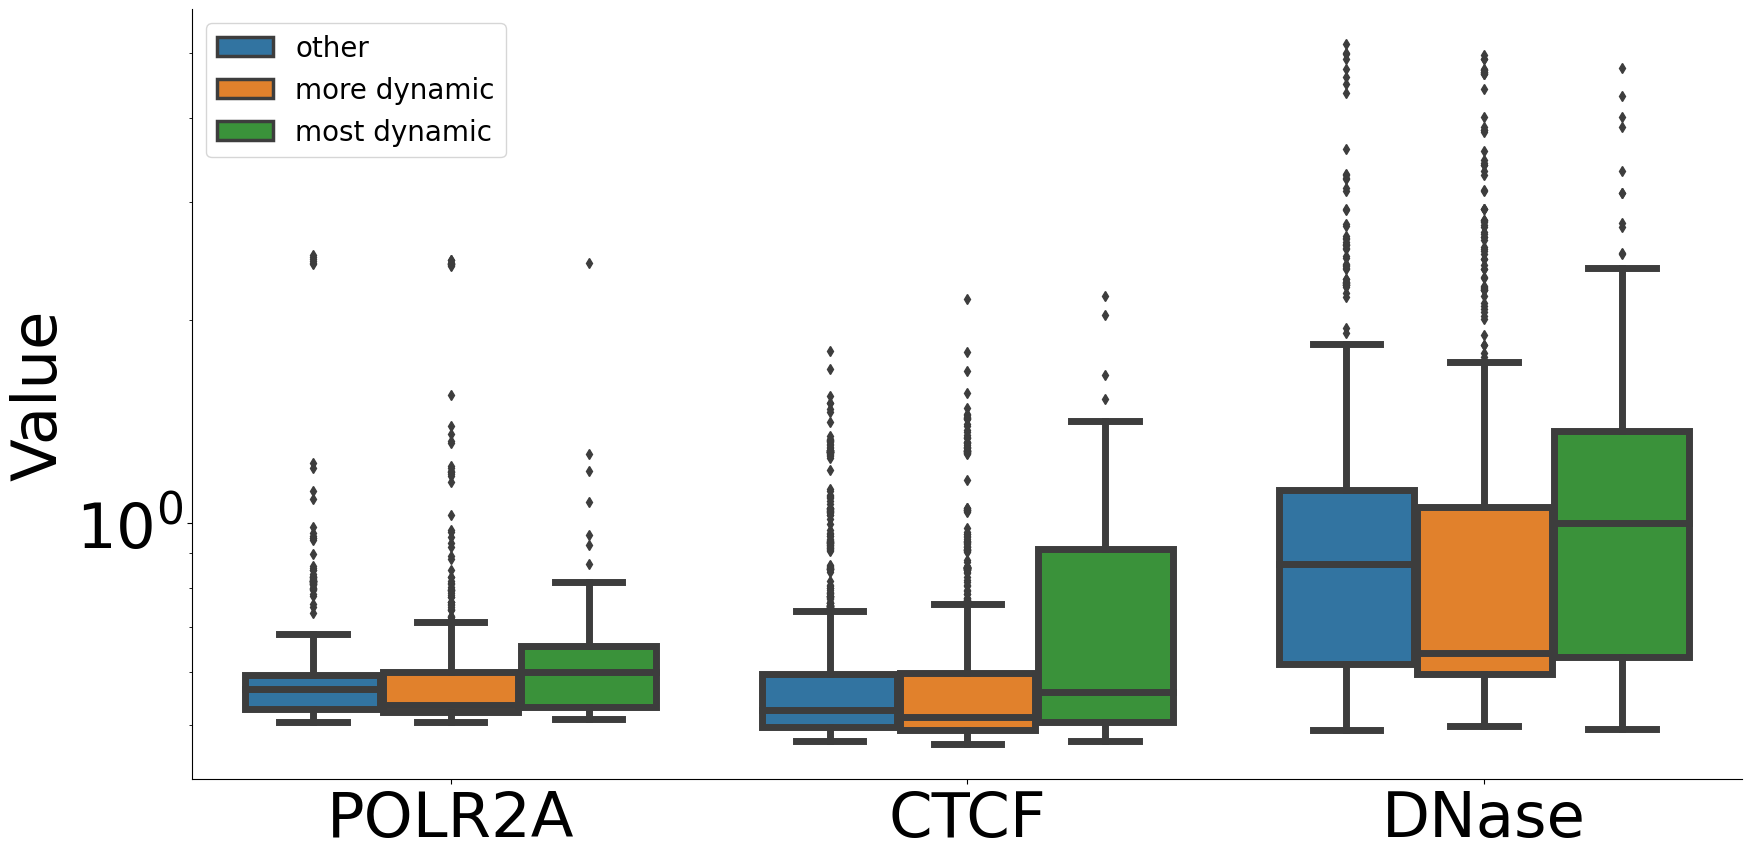

In [6]:
threshold = [0.0085, 0.012]

infos_Astro_POLR2A = dynamic_vs_ChIP(
    [('Astro', 'SLC1A2'), ('Astro', 'SLC1A3'), ('Astro', 'GPM6A')], 'diff_hic', threshold, Astro_POLR2A
)
infos_ODC_POLR2A = dynamic_vs_ChIP(
    [('ODC', 'MBP'), ('ODC', 'QKI'), ('ODC', 'DOCK10')], 'diff_hic', threshold, Astro_POLR2A
)
infos_Astro_POLR2A['chip'] = infos_ODC_POLR2A['chip'] = 'POLR2A'

infos_Astro_CTCF = dynamic_vs_ChIP(
    [('Astro', 'SLC1A2'), ('Astro', 'SLC1A3'), ('Astro', 'GPM6A')], 'diff_hic', threshold, Astro_CTCF
)
infos_ODC_CTCF = dynamic_vs_ChIP(
    [('ODC', 'MBP'), ('ODC', 'QKI'), ('ODC', 'DOCK10')], 'diff_hic', threshold, Astro_CTCF
)
infos_Astro_CTCF['chip'] = infos_ODC_CTCF['chip'] = 'CTCF'

infos_Astro_DNase = dynamic_vs_ChIP(
    [('Astro', 'SLC1A2'), ('Astro', 'SLC1A3'), ('Astro', 'GPM6A')], 'diff_hic', threshold, Astro_DNase
)
infos_ODC_DNase = dynamic_vs_ChIP(
    [('ODC', 'MBP'), ('ODC', 'QKI'), ('ODC', 'DOCK10')], 'diff_hic', threshold, Astro_DNase
)
infos_Astro_DNase['chip'] = infos_ODC_DNase['chip'] = 'DNase'



set_plt(figsize=(20, 10))
fig, ax = plt.subplots()


ax = sns.boxplot(
    x='chip', y='value', hue='dynamic', data=pd.concat([
        infos_Astro_POLR2A, infos_ODC_POLR2A, infos_Astro_CTCF, infos_ODC_CTCF, infos_Astro_DNase, infos_ODC_DNase
    ]),
    order=['POLR2A', 'CTCF', 'DNase'], hue_order=['other', 'more dynamic', 'most dynamic'],
    linewidth=figure_size['very_small']
)
plt.yscale('log')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.legend(title="")
plt.grid(False)

plt.xlabel("")
plt.ylabel("Value", fontsize=figure_size['ultra'])
plt.savefig(
    '/lmh_data/work/SEE/analyse/figure_file/vibration/difference(ChIP).pdf', format='pdf', bbox_inches='tight')
plt.show()

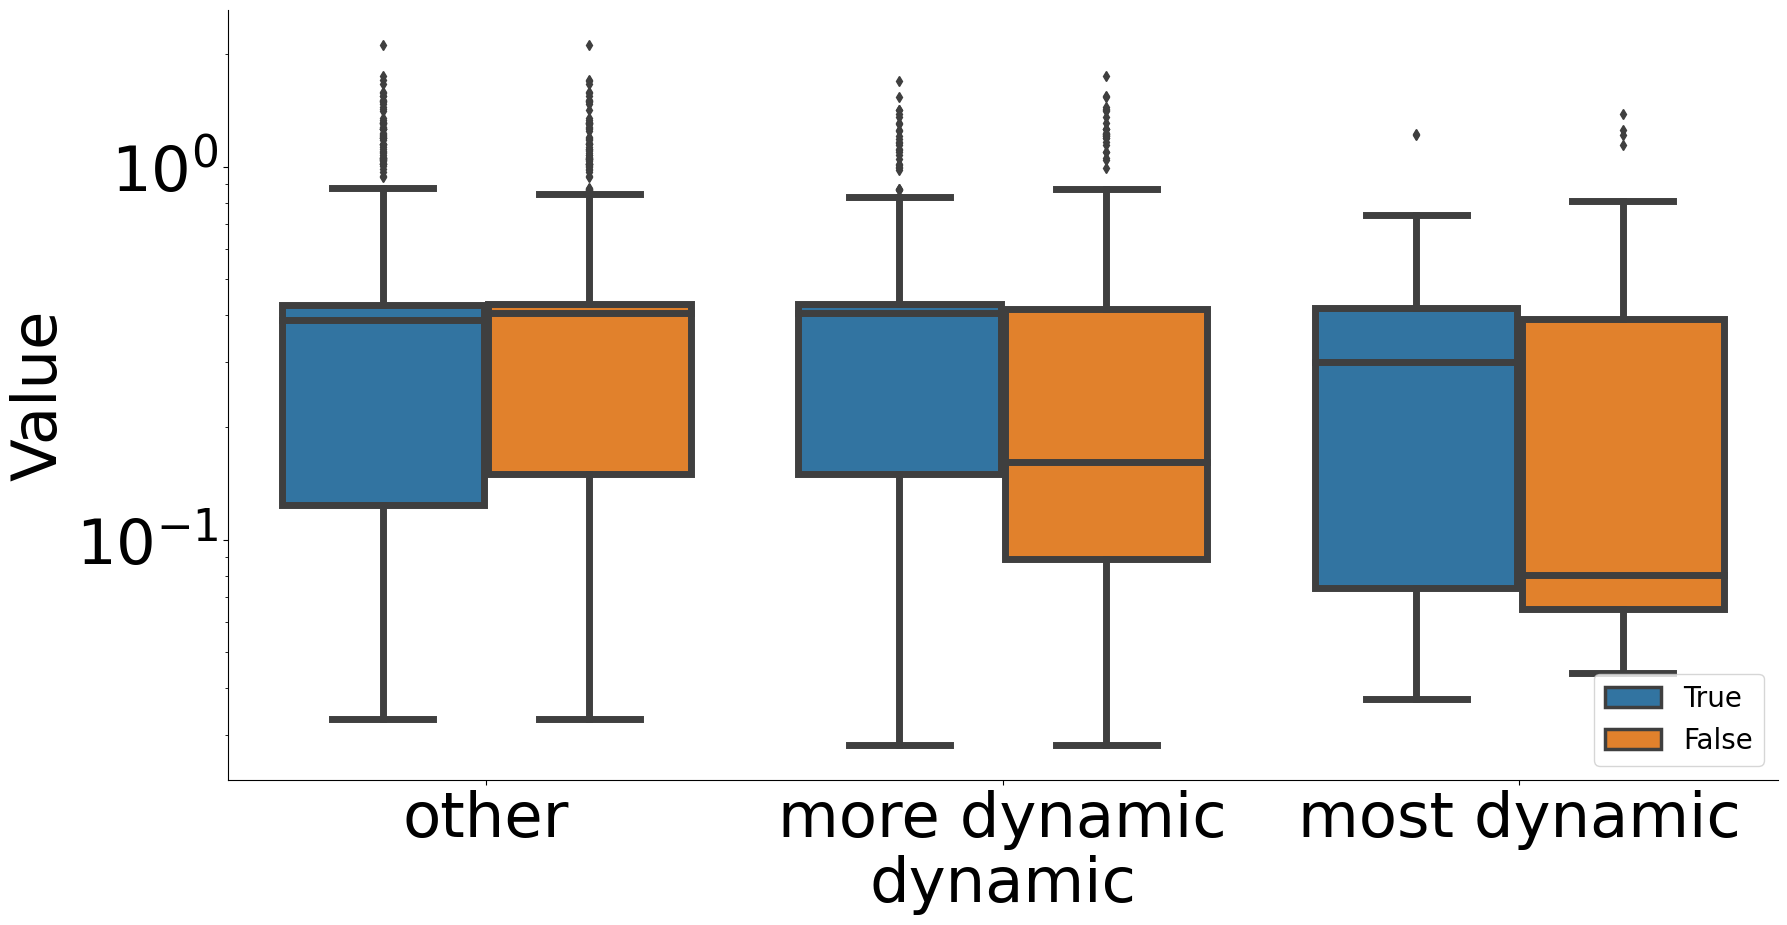

In [7]:
threshold = [0.0085, 0.012]

Astro_marker = dynamic_vs_ChIP(
    [('Astro', 'SLC1A2'), ('Astro', 'SLC1A3'), ('Astro', 'GPM6A')], 'diff_hic', threshold, Astro_H3K27ac
)
ODC_marker = dynamic_vs_ChIP(
    [('ODC', 'MBP'), ('ODC', 'QKI'), ('ODC', 'DOCK10')], 'diff_hic', threshold, ODC_H3K27ac
)
Astro_marker['differential exp'] = ODC_marker['differential exp'] = 'True'

Astro_silence = dynamic_vs_ChIP(
    [('ODC', 'SLC1A2'), ('ODC', 'SLC1A3'), ('ODC', 'GPM6A')], 'diff_hic', threshold, Astro_H3K27ac
)
ODC_silence = dynamic_vs_ChIP(
    [('Astro', 'MBP'), ('Astro', 'QKI'), ('Astro', 'DOCK10')], 'diff_hic', threshold, ODC_H3K27ac
)
Astro_silence['differential exp'] = ODC_silence['differential exp'] = 'False'



set_plt(figsize=(20, 10))
fig, ax = plt.subplots()

ax = sns.boxplot(
    x='dynamic', y='value', hue='differential exp',
    data=pd.concat([Astro_marker, ODC_marker, Astro_silence, ODC_silence]),
    order=['other', 'more dynamic', 'most dynamic'],
    linewidth=figure_size['very_small']
)
plt.yscale('log')

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.legend(title="")
plt.grid(False)

plt.ylabel("Value", fontsize=figure_size['ultra'])
plt.savefig(
    '/lmh_data/work/SEE/analyse/figure_file/vibration/difference(DEG).pdf', format='pdf', bbox_inches='tight')
plt.show()